In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [42]:
#Essentials
import numpy as np
import pandas as pd
import pickle
import re
from sklearn.pipeline import Pipeline

#Plotting fun
import matplotlib.pyplot as plt
import seaborn as sns

#NLP fun
import nltk
from  collections  import namedtuple

#Text cleaning (stemming, lemmatizing, etc.)
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import inflection
from autocorrect import spell

#Vectorizing
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

# Dimentionality reduction
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation, PCA

#NLP clustering
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, DBSCAN

#Clustering help
from sklearn.metrics import silhouette_score


#Clustering visualization
from sklearn.manifold import TSNE


#Neural nets
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# import torch.nn.functional as F
# from scipy.cluster.hierarchy import dendrogram, linkage

#Fun stuff
import pyLDAvis
import pyLDAvis.sklearn

#Nice to have
# from collections import Counter
#from gensim import corpora, models, similarities, matutils, Word2vec, emoji2vec
# from nltk.tokenize import TreebankWordTokenizer
# from nltk.tokenize import wordpunct_tokenize
# from nltk.chunk import ne_chunk
# from nltk.corpus import treebank_chunk
# from operator import itemgetter

%matplotlib inline

### Helper functions

In [3]:
def simple_pos(pos):
    if pos == 'NOUN':
        return 'n'
    elif pos == 'VERB':
        return 'v'
    elif pos == 'ADJ':
        return 'a'
    elif pos == 'ADV':
        return 'r'
    elif pos == 'ADJ_SAT':
        return 's'
    else:
        return 'n'


def process_words(string):
    """Takes a string as input.
    Returns the string after lemmatizing and singularizing the words."""
    processed_string = string
    lmtzr = WordNetLemmatizer()
    word_pos_pair = pos_tag(word_tokenize(processed_string), tagset='universal')
    for word, pos in word_pos_pair:
        word_pos = simple_pos(pos)
        #spell_correct = ' '+spell(word) if "'" in word else spell(word)
        lame_word = lmtzr.lemmatize(word, word_pos)
        singular_word = inflection.singularize(lame_word)
        processed_string = processed_string.replace(word, singular_word)
    return processed_string 
    
    
# def display_topics(model, feature_names, no_top_words, topic_names=None):
#     for ix, topic in enumerate(model.components_):
#         if not topic_names or not topic_names[ix]:
#             print("\nTopic ", ix)
#         else:
#             print("\nTopic: '",topic_names[ix],"'")
#         print(", ".join([feature_names[i]
#                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [4]:
#Testing
print(process_words("flying brilliant flightled"))
print(process_words("bleeming cancelledr flights"))
print(process_words("I like delays less than you because don't the o..."))

fly brilliant flightled
bleeming cancelledr flight
I like delay less than you because don't the o...


In [5]:
#Moving forward read from pickle rather than repeat above steps
with open('negative_tweets.pkl', 'rb') as picklefile:
    negative_tweets = pickle.load(picklefile)

In [6]:
negative_tweets = negative_tweets.drop(columns=['tweet', 'retweet_count', 'sentiment'])
negative_tweets.head()

,airline,tweet_clean
1,Delta,is REALLY getting on my nerves !!
2,United,yes. We waited in line for almost an hour to ...
3,United,the we got into the gate at on time and have...
6,United,I like delays less than you because I'm the o...
7,United,", link to current status of flights/airports? ..."


## Now, it's time to vectorize the tweets

In [7]:
#Some prep work (lemmatize)
tweet_col = negative_tweets['tweet_clean']
tweet_col = [process_words(tweet) for tweet in tweet_col]


In [8]:
tweet_col[:10]

[' be REALLY get on my nerve !!  ',
 ' ye. We wait in line for almost an hour to do so. Some passenger just leave not want to wait past be.',
 ' the we get into the gate at  on time and have give our seat and close the flight. If you know person be arrive, have to wait',
 " I like delay less than you because I'm the one on the plane. Connect me with a voucher",
 ", link to current status of flights/airport? Fly BWI-EWR-MCO thi morning yet can't yet tell what any problem be except see snow.",
 ' I try  DM it would not go thru... not sure why',
 " i have item of sentimental value that I'm heartbroken be miss",
 ' We have be stick in  for several hour and no one be answer here. Really tough to  SW. No response be bad.',
 ' be officially the bad, most delay, and least helpful airline I have ever have the mbefortune of fly on',
 " won't answer their phone    "]

In [9]:
#Some prep work (removing some of the most popular, but not indicative words)
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '!', ':', 'DM', 'amp', 'yes', 'no', 'thi', 'flight', 'fly', 'flightled', 'get']
stop = set(stop)

#### Count Vectorizer method

In [10]:
params = {
            'strip_accents': 'ascii',
            'lowercase': True,
            'stop_words': stop, 
            'min_df': 10,
            'ngram_range': (1, 2)
         }

In [73]:
#Count vectorizer case
count_vec = CountVectorizer(**params)
negative_tweets_cv_viz = count_vec.fit_transform(tweet_col)
negative_tweets_cv = negative_tweets_cv_viz.toarray()
negative_tweets_cv = pd.DataFrame(negative_tweets_cv, columns=count_vec.get_feature_names())
negative_tweets_cv.head()

,aa,able,absolute,absolutely,accept,acceptable,access,accommodate,account,actually,...,wrong,wtf,yall,ye,yeah,year,yesterday,yet,yr,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


#### TF-IDF method

In [55]:
#TF-IDF 
tfidf_vec = TfidfVectorizer(**params)
negative_tweets_tfidf_viz = tfidf_vec.fit_transform(tweet_col)
negative_tweets_tfidf = negative_tweets_tfidf_viz.toarray()
negative_tweets_tfidf = pd.DataFrame(negative_tweets_tfidf, columns=tfidf_vec.get_feature_names())
negative_tweets_tfidf.head()

,aa,able,absolute,absolutely,accept,acceptable,access,accommodate,account,actually,...,wrong,wtf,yall,ye,yeah,year,yesterday,yet,yr,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.31459,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.507208,0.0,0.0


In [13]:
#Explore the matrix to see which words show up the most and evaluate
# total_words = negative_tweets_cv.shape
# total_words = total_words[0]
# word_summary = negative_tweets_cv.sum().sort_values(ascending=False)
# word_frequency = pd.DataFrame(word_summary, columns=['freq'])
# word_frequency['freq_prop'] = [freq / total_words for freq in word_frequency['freq']]
# word_frequency.head(50)

## Dimensionality reduction fun

In [99]:
#Number of topics
n_topics = 7
n_words = 10
n_iter = 5

#### Different dimensionality reduction techniques applied CountVectorized data

In [100]:
#CountVectorizer + LSA
lsa_cv_model = TruncatedSVD(n_components=n_topics)
lsa_cv_data = lsa_cv_model.fit_transform(negative_tweets_cv)

In [ ]:
# print('Count vectorizer and LSA:')
display_topics(lsa_cv_model, count_vec.get_feature_names(), n_words)

In [102]:
#CountVectorizer + NMF
nmf_cv_model = NMF(n_components=n_topics)
nmf_cv_data = nmf_cv_model.fit_transform(negative_tweets_cv)

In [103]:
print('Count vectorizer and NMF:')
display_topics(nmf_cv_model, count_vec.get_feature_names(), n_words)

Count vectorizer and NMF:

Topic  0
late, call, flightr, late flightr, back, call back, hr, hour late, still, tell

Topic  1
service, customer, customer service, bad, ever, terrible, airline, worst, experience, bad customer

Topic  2
cancelled, flighted, cancelled flighted, hold, tomorrow, today, weather, rebook, hr, help

Topic  3
delay, hr, hour delay, due, ua, crew, delay hour, connection, plane, delay due

Topic  4
hour, hold, wait, plane, hold hour, sit, hour delay, hour late, half, hour hold

Topic  5
time, wait, min, minute, airline, wait time, hold, every, first, last

Topic  6
bag, plane, gate, day, one, make, go, bad, seat, wait


In [104]:
#CountVectorizer + LDA
lda_cv_model = LatentDirichletAllocation(n_components=n_topics,
                                    max_iter=n_iter,
                                    random_state=42,
                                    learning_method='online')

lda_cv_data = lda_cv_model.fit_transform(negative_tweets_cv);

In [105]:
# print('Count vectorizer and LDA:')
# display_topics(lda_cv_model, count_vec.get_feature_names(), n_words)

In [106]:
#CountVectorizer + PCA
pca_cv_model = PCA(n_components=n_topics, random_state=42)
pca_cv_data = pca_cv_model.fit_transform(negative_tweets_cv);

In [107]:
# print('Count vectorizer and PCA:')
display_topics(pca_cv_model, count_vec.get_feature_names(), n_words)

Count vectorizer and PCA:

Topic  0
service, customer, customer service, bad, ever, terrible, worst, bad customer, airline, experience

Topic  1
cancelled, flighted, cancelled flighted, hold, tomorrow, customer, today, rebook, customer service, help

Topic  2
hour, delay, cancelled, hold, service, customer, wait, customer service, plane, late

Topic  3
delay, cancelled, time, bad, due, hour delay, weather, airline, ua, delay due

Topic  4
time, call, late, delay, flightr, late flightr, hr, min, back, wait

Topic  5
bag, late, delay, flightr, late flightr, hr, still, cancelled, lose, day

Topic  6
bag, wait, lose, time, check, gate, hold, min, still, baggage


#### Different dimensionality reduction techniques applied TF-IDFed data

In [108]:
# #LSA + TF-IDF
lsa_tfidf_model = TruncatedSVD(n_components=n_topics)
lsa_tfidf_data = lsa_tfidf_model.fit_transform(negative_tweets_tfidf)

In [ ]:
# print('TF-IDF and LSA:')
display_topics(lsa_tfidf_model, tfidf_vec.get_feature_names(), n_words)

In [110]:
#TF-IDF + PCA
pca_tfidf_model = PCA(n_components=n_topics, random_state=42)
pca_tfidf_data = pca_tfidf_model.fit_transform(negative_tweets_cv);

In [ ]:
# print('TF-IDF and PCA:')
display_topics(pca_tfidf_model, tfidf_vec.get_feature_names(), n_words)

In [112]:
#LDA + TF-IDF
lda_tfidf_model = LatentDirichletAllocation(n_components=n_topics,
                                    max_iter=n_iter,
                                    random_state=42,
                                    learning_method='online')

lda_tfidf_data = lda_tfidf_model.fit_transform(negative_tweets_tfidf)

In [113]:
# print('TF-IDF and LDA:')
# display_topics(lda_tfidf_model, tfidf_vec.get_feature_names(), n_words)

### Maybe visualizing the results will help

In [114]:
#Prep for viz
LDA_CV = [lda_cv_model, negative_tweets_cv_viz, count_vec]
LDA_TFIDF = [lda_tfidf_model, negative_tweets_tfidf_viz, tfidf_vec]

In [120]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(*LDA_CV, mds='tsne') #options for scaling mds='tsne' or mds='mmds'

PreparedData(topic_coordinates=            Freq  cluster  topics          x          y
topic                                                  
5      17.225992        1       1  95.675835 -25.488081
1      17.007683        1       2  61.709797  34.713474
4      16.501151        1       3  -8.596409 -84.319252
2      12.844419        1       4  60.522850 -85.004326
0      12.838372        1       5  26.556688 -24.802839
3      12.253775        1       6 -42.562431 -24.117632
6      11.328607        1       7  -7.409726  35.398739, topic_info=     Category        Freq                Term       Total  loglift  logprob
term                                                                       
665   Default  472.000000             service  472.000000  30.0000  30.0000
193   Default  407.000000            customer  407.000000  29.0000  29.0000
114   Default  292.000000                call  292.000000  28.0000  28.0000
206   Default  519.000000               delay  519.000000  27.0000  27.0000
332   Default  239.000000                gate  239.000000  26.0000  26.0000
78    Default  307.000000                 bag  307.000000  25.0000  25.0000
194   Default  257.000000    customer service  257.000000  24.0000  24.0000
543   Default  251.000000                 one  251.000000  23.0000  23.0000
119   Default  633.000000           cancelled  633.000000  22.0000  22.0000
428   Default  279.000000                late  279.000000  21.0000  21.0000
72    Default  308.000000                 bad  308.000000  20.0000  20.0000
598   Default  187.000000             problem  187.000000  19.0000  19.0000
840   Default  167.000000             weather  167.000000  18.0000  18.0000
570   Default  192.000000               phone  192.000000  17.0000  17.0000
498   Default  156.000000              minute  156.000000  16.0000  16.0000
757   Default  151.000000              ticket  151.000000  15.0000  15.0000
242   Default  160.000000                 due  160.000000  14.0000  14.0000
304   Default  154.000000            flighted  154.000000  13.0000  13.0000
382   Default  235.000000                  hr  235.000000  12.0000  12.0000
122   Default  153.000000  cancelled flighted  153.000000  11.0000  11.0000
613   Default  140.000000              really  140.000000  10.0000  10.0000
14    Default  185.000000               agent  185.000000   9.0000   9.0000
335   Default  258.000000                  go  258.000000   8.0000   8.0000
261   Default  136.000000                even  136.000000   7.0000   7.0000
654   Default  222.000000                seat  222.000000   6.0000   6.0000
434   Default  155.000000               leave  155.000000   5.0000   5.0000
825   Default  299.000000                wait  299.000000   4.0000   4.0000
18    Default  237.000000             airline  237.000000   3.0000   3.0000
578   Default  336.000000               plane  336.000000   2.0000   2.0000
375   Default  569.000000                hour  569.000000   1.0000   1.0000
...       ...         ...                 ...         ...      ...      ...
130    Topic7   37.101284                 car   37.941099   2.1555  -4.7481
9      Topic7   30.485613            actually   31.325762   2.1507  -4.9445
240    Topic7   29.990293               drive   30.840038   2.1499  -4.9608
599    Topic7   29.385940             process   30.225102   2.1497  -4.9812
352    Topic7   29.002983               happy   29.842940   2.1493  -4.9943
261    Topic7  132.718322                even  136.576849   2.1492  -3.4735
619    Topic7   28.671685    reflight booking   29.512385   2.1489  -5.0058
618    Topic7   28.671658            reflight   29.512400   2.1489  -5.0058
326    Topic7   29.055855                fuck   29.917826   2.1486  -4.9925
484    Topic7   28.194609              member   29.037346   2.1484  -5.0226
127    Topic7   25.730197              cannot   26.569819   2.1457  -5.1141
644    Topic7   25.623895                ruin   26.470631   2.1453  -5.1182
354    Topic7   32.844856        

In [116]:
pyLDAvis.sklearn.prepare(*LDA_TFIDF, mds='tsne') #options for scaling mds='tsne' or mds='mmds'

PreparedData(topic_coordinates=            Freq  cluster  topics          x          y
topic                                                  
5      23.851639        1       1 -16.749935 -19.747025
1      15.449740        1       2  58.054649 -14.398724
3      14.775027        1       3  20.650656 -17.072517
4      14.569386        1       4   4.266241 -50.800056
2      11.924943        1       5  -0.365618  13.981448
0       9.944936        1       6  41.666885 -48.125080
6       9.484328        1       7  37.037132  16.656641, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
665   Default  108.000000           service  108.000000  30.0000  30.0000
194   Default   67.000000  customer service   67.000000  29.0000  29.0000
193   Default   95.000000          customer   95.000000  28.0000  28.0000
721   Default   41.000000              suck   41.000000  27.0000  27.0000
332   Default   61.000000              gate   61.000000  26.0000  26.0000
598   Default   54.000000           problem   54.000000  25.0000  25.0000
263   Default   40.000000              ever   40.000000  24.0000  24.0000
844   Default   30.000000              week   30.000000  23.0000  23.0000
840   Default   48.000000           weather   48.000000  22.0000  22.0000
428   Default   68.000000              late   68.000000  21.0000  21.0000
635   Default   29.000000         ridiculou   29.000000  20.0000  20.0000
615   Default   27.000000            rebook   27.000000  19.0000  19.0000
102   Default   27.000000   booking problem   27.000000  18.0000  18.0000
101   Default   27.000000           booking   27.000000  17.0000  17.0000
570   Default   48.000000             phone   48.000000  16.0000  16.0000
750   Default   26.000000             thing   26.000000  15.0000  15.0000
613   Default   47.000000            really   47.000000  14.0000  14.0000
72    Default   84.000000               bad   84.000000  13.0000  13.0000
338   Default   32.000000              good   32.000000  12.0000  12.0000
456   Default   54.000000              lose   54.000000  11.0000  11.0000
18    Default   67.000000           airline   67.000000  10.0000  10.0000
850   Default   25.000000              wifi   25.000000   9.0000   9.0000
273   Default   39.000000        experience   39.000000   8.0000   8.0000
444   Default   42.000000              like   42.000000   7.0000   7.0000
14    Default   48.000000             agent   48.000000   6.0000   6.0000
307   Default   30.000000           flightr   30.000000   5.0000   5.0000
429   Default   30.000000      late flightr   30.000000   4.0000   4.0000
785   Default   34.000000              trip   34.000000   3.0000   3.0000
500   Default   53.000000              miss   53.000000   2.0000   2.0000
211   Default   29.000000           delayed   29.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
576    Topic7   10.010406             place   10.825730   2.2772  -4.8197
271    Topic7   12.885865            expect   13.976521   2.2743  -4.5672
281    Topic7    9.466327           failure   10.282067   2.2729  -4.8756
450    Topic7    9.440497              live   10.255724   2.2727  -4.8783
128    Topic7    9.393513              cant   10.208747   2.2723  -4.8833
90     Topic7    9.349342            beyond   10.164272   2.2720  -4.8880
301    Topic7    9.317840             fleet   10.132406   2.2717  -4.8914
285    Topic7    9.183259              fare    9.997491   2.2706  -4.9059
790    Topic7    9.098716            trying    9.913907   2.2697  -4.9152
174    Topic7    8.535911          consider    9.351003   2.2643  -4.9790
504    Topic7    8.122028           mistake    8.939039   2.2597  -5.0287
519    Topic7    8.010944         need help    8.826140   2.2586  -5.0425
703    Topic7    7.942192             state    8.757395   2.2578  -5.0511
642    Topic7    7.673962                rt    8.

## Clustering Time!

In [33]:
#Let's start with KMeans
inertia = [0,0]

for n_clusters in range(2, 16):
    km = KMeans(n_clusters = n_clusters)
    km.fit(lda_tfidf_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 858.610734
# clusters:  3   Inertia: 725.695053
# clusters:  4   Inertia: 634.153209
# clusters:  5   Inertia: 551.822973
# clusters:  6   Inertia: 492.627760
# clusters:  7   Inertia: 439.750042
# clusters:  8   Inertia: 391.476203
# clusters:  9   Inertia: 354.442073
# clusters: 10   Inertia: 321.189767
# clusters: 11   Inertia: 305.027246
# clusters: 12   Inertia: 293.449230
# clusters: 13   Inertia: 283.636377
# clusters: 14   Inertia: 276.112475
# clusters: 15   Inertia: 271.097805


Text(0,0.5,'Inertia')

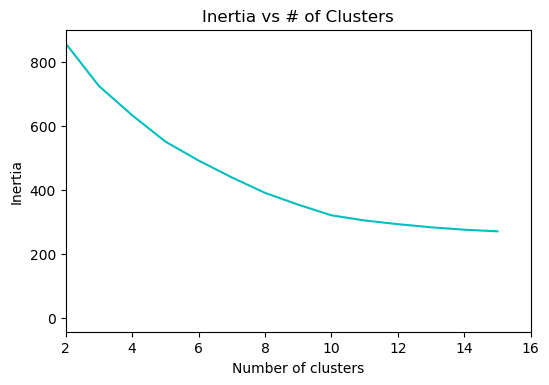

In [34]:
plt.figure(dpi=100)
plt.plot(inertia, color='c')
plt.title('Inertia vs # of Clusters')
plt.xlim(2, 16)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

### Let's start at the beginning (K-Means)

In [35]:
lsa_cv_tsne = TSNE(n_components = 2, perplexity = 30.0)
nmf_cv_tsne = TSNE(n_components = 2, perplexity = 30.0)
lda_cv_tsne = TSNE(n_components = 2, perplexity = 30.0)
pca_cv_tsne = TSNE(n_components = 2, perplexity = 30.0)
lsa_tfidf_tsne = TSNE(n_components = 2, perplexity = 30.0)
lda_tfidf_tsne = TSNE(n_components = 2, perplexity = 30.0)
pca_tfidf_tsne = TSNE(n_components = 2, perplexity = 30.0)

lsa_cv_sne = lsa_cv_tsne.fit_transform(lsa_cv_data)
nmf_cv_sne = nmf_cv_tsne.fit_transform(nmf_cv_data)
lda_cv_sne = lda_cv_tsne.fit_transform(lda_cv_data)
pca_cv_sne = pca_cv_tsne.fit_transform(pca_cv_data)
lsa_tfidf_sne = lsa_tfidf_tsne.fit_transform(lsa_tfidf_data)
lda_tfidf_sne = lda_tfidf_tsne.fit_transform(lda_tfidf_data)
pca_tfidf_sne = pca_tfidf_tsne.fit_transform(pca_tfidf_data)

tSNE for different Count Vectorizer models


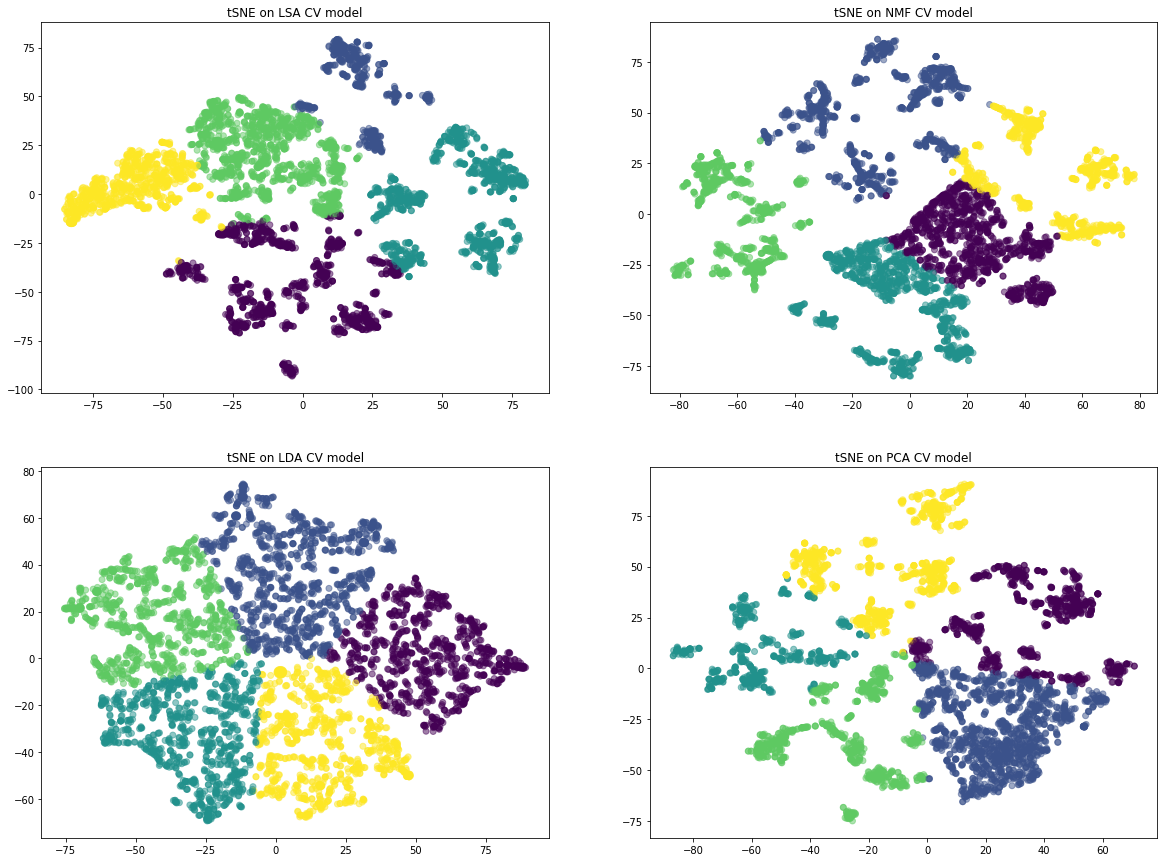

In [36]:
n_clusters = 5

print('tSNE for different Count Vectorizer models')

km_lsa_cv = KMeans(n_clusters = n_clusters)
km_nmf_cv = KMeans(n_clusters = n_clusters)
km_lda_cv = KMeans(n_clusters = n_clusters)
km_pca_cv = KMeans(n_clusters = n_clusters)


km_lsa_cv.fit(lsa_cv_sne)
km_nmf_cv.fit(nmf_cv_sne)
km_lda_cv.fit(lda_cv_sne)
km_pca_cv.fit(pca_cv_sne)


plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)    

plt.scatter(lsa_cv_sne[:, 0], lsa_cv_sne[:, 1], c=km_lsa_cv.labels_, alpha=0.5)
plt.title('tSNE on LSA CV model');

plt.subplot(2, 2, 2)    
plt.scatter(nmf_cv_sne[:, 0], nmf_cv_sne[:, 1], c=km_nmf_cv.labels_, alpha=0.5)
plt.title('tSNE on NMF CV model');

plt.subplot(2, 2, 3)    
plt.scatter(lda_cv_sne[:, 0], lda_cv_sne[:, 1], c=km_lda_cv.labels_, alpha=0.5)
plt.title('tSNE on LDA CV model');

plt.subplot(2, 2, 4)    
plt.scatter(pca_cv_sne[:, 0], pca_cv_sne[:, 1], c=km_pca_cv.labels_, alpha=0.5)
plt.title('tSNE on PCA CV model');


tSNE for different TF-IDF models


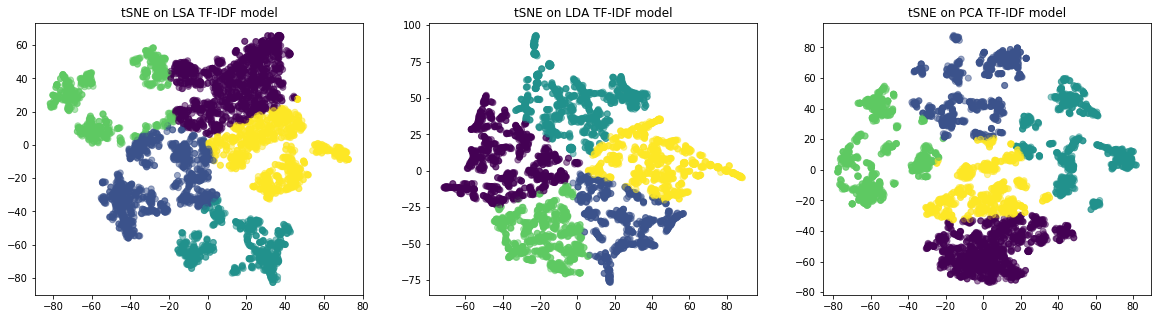

In [40]:
print('tSNE for different TF-IDF models')
km_lsa_tfidf = KMeans(n_clusters = n_clusters)
km_lda_tfidf = KMeans(n_clusters = n_clusters)
km_pca_tfidf = KMeans(n_clusters = n_clusters)

km_lsa_tfidf.fit(lsa_tfidf_sne)
km_lda_tfidf.fit(lda_tfidf_sne)
km_pca_tfidf.fit(pca_tfidf_sne)

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)      
plt.scatter(lsa_tfidf_sne[:, 0], lsa_tfidf_sne[:, 1], c=km_lsa_tfidf.labels_, alpha=0.5)
plt.title('tSNE on LSA TF-IDF model');

plt.subplot(1, 3, 2)     
plt.scatter(lda_tfidf_sne[:, 0], lda_tfidf_sne[:, 1], c=km_lda_tfidf.labels_, alpha=0.5)
plt.title('tSNE on LDA TF-IDF model');

plt.subplot(1, 3, 3)     
plt.scatter(pca_tfidf_sne[:, 0], pca_tfidf_sne[:, 1], c=km_pca_tfidf.labels_, alpha=0.5)
plt.title('tSNE on PCA TF-IDF model');

### What about other models?

#### Multinomial Naive Bayes

In [ ]:
issues = ['Flight Cancelled', 'Flight Delayed', 'Bad Customer Service', 'Lost Baggage']

MNB_model = MultinomialNB()
MNB_model.fit(lda_tfidf_data, issues)

In [ ]:
new_tweet = "I can't believe my flight was cancelled an hour before departure"
MNB_model.predict_proba(new_tweet)

#### DBSCAN

### Summarize the best model

In [ ]:
def classify_issue(string, classifier):
    """Takes a string (tweet).
    Returns an issue class it belongs to (based on the pretrained model)."""
    issue = classifier.(string)
    return issue

## Model is done, let's test it and pickle for later

#### Testing fun

In [ ]:
test_tweet1 = tweet_test[np.random.choice(count(tweet_test['tweet_clean']))]
classify_issue(test_tweet1)

## Et Voila! Let's recommend some actions!

In [ ]:
def make_suggestion(string):
    """Takes a string, puts it through a pipeline of actions:
            1. Defines the sentiment (if NOT negative, returns 'You have a happy customer')
            2. Cleans the string (removes codes, hashtags, emojis, airlines, etc.)
            3. Processes words (lemmatization, singularization, etc.)
            4. Classifies into one of ... topics"""
    #Defining an action for each issue
    action_dict = {'Flight Cancelled': 'Please Improve Your Scheduling (where possible)'
                  'Flight Delays': 'Please Improve Your Scheduling (where possible)'}
    
    sentiment = get_sentiment(string)
    if sentiment != 'negative':
        return emoji.emojize('Keep up the good work! \U0001F60C')
    else:
        issue = Pipeline(get_clean_tweet(string), process_words(string), classify_issue(string))
    
    #Now finally choose the action
    return action_dict[issue]
    
    

### Building the pipeline for future tweet classification